## Info

This notebook contains the code for analyzing sequence conservation around the regulatory element (e.g. phyloP)

In [1]:
%run '~/jupyter/py3_functions.py'
%run '/n/home11/twooldridge/scripts/polionotus_project/polionotus_setup.py'
setupWorkspace('/n/hoekstra_lab_tier1/Users/brock/polionotus/conservation_plot/')


#from Bio import SeqIO
%matplotlib inline
from IPython.display import display
from bokeh.plotting import figure, show, save, output_notebook, output_file
from bokeh.models import ColumnDataSource,HoverTool,CategoricalColorMapper,Range1d
from bokeh.models import BoxSelectTool,BoxZoomTool,LassoSelectTool,Legend
from bokeh.io import export_png
from bokeh.layouts import column,gridplot

## R
from rpy2 import rinterface
from jupyter_helpers import rpy2_autocompletion
%load_ext rpy2.ipython


## Input data

Download rodent Agouti sequences

In [1]:
%%bash
### only rodents

### pull out gene coordinates for all rodent ASIP orthologs
esearch -db gene -query "ortholog_gene_434[group] AND rodents[orgn]" \
    | esummary -db gene \
    | xtract -pattern DocumentSummary -element ScientificName -block LocationHist -element 'ChrAccVer,ChrStart,ChrStop' \
    | awk -F "\t" 'BEGIN{OFS="\t"} {count=0; for (i=2;i<=NF;i++) if ($i~"[A_Z]") count++; if (count>1) print $1,$2,$(2+count)+1,$(2+count*2)+1; else print $1,$2,$3+1,$4+1}' \
    | sed 's/ /_/g' > NCBI.orthogroup_434.rodents.gene_coords.tsv
## pull out all sequences
while IFS=$'\t' read SPC ACC START END

do 
    efetch -db nucleotide -id "$ACC" -chr_start "$START" -chr_stop "$END" -format fasta

done > NCBI.orthogroup_434.rodents.fasta < NCBI.orthogroup_434.rodents.gene_coords.tsv




### add 15kb padding
awk -v padding="15000" 'BEGIN{OFS="\t"} {if ($3<$4) {start=$3-padding; end=$4+padding} else {start=$3+padding; end=$4-padding} \
    if (start<1) start=1; if (end<1) end=1; print $1,$2,start,end}' \
    NCBI.orthogroup_434.rodents.gene_coords.tsv > NCBI.orthogroup_434.rodents.gene_coords.15kb_pad.tsv




### pull out sequences
while IFS=$'\t' read SPC ACC START END

do 
    efetch -db nucleotide -id "${ACC}" -chr_start "${START}" -chr_stop "${END}" -format fasta \
    > ${SPC}.asip.15kb_pad.fasta
 
done < NCBI.orthogroup_434.rodents.gene_coords.15kb_pad.tsv

Can't locate IO/Socket/SSL.pm in @INC (you may need to install the IO::Socket::SSL module) (@INC contains: /n/home11/twooldridge/edirect/aux/lib/perl5/x86_64-linux-thread-multi /n/home11/twooldridge/edirect/aux/lib/perl5 /n/home11/twooldridge/apps/perl /n/home11/twooldridge/apps/perl/lib/perl5/x86_64-linux-thread-multi /n/home11/twooldridge/apps/perl/lib/perl5 /n/home11/twooldridge/.conda/envs/doom/lib/perl5/5.32/site_perl /n/home11/twooldridge/.conda/envs/doom/lib/perl5/site_perl /n/home11/twooldridge/.conda/envs/doom/lib/perl5/5.32/vendor_perl /n/home11/twooldridge/.conda/envs/doom/lib/perl5/vendor_perl /n/home11/twooldridge/.conda/envs/doom/lib/perl5/5.32/core_perl /n/home11/twooldridge/.conda/envs/doom/lib/perl5/core_perl .) at /n/home11/twooldridge/edirect/edirect.pl line 70.
BEGIN failed--compilation aborted at /n/home11/twooldridge/edirect/edirect.pl line 70.
Can't locate IO/Socket/SSL.pm in @INC (you may need to install the IO::Socket::SSL module) (@INC contains: /n/home11/twoo

Get rodent sequences together for alignment

In [ ]:
%%bash
rm rodent_agouti.fasta;~/Software/newick-utils-1.6/src/nw_labels rodents_cladogram.nwk | cut -d '_' -f1 | sort -u | while read GENUS;do ls NCBI_sequences/$GENUS* | xargs -I {} cat {} >> rodent_agouti.fasta;done

Run alignment

In [ ]:
%%bash
sbatch -e alignment.err -o alignment.out -J alignment --mem=30000 --time=24:00:00 -N 1 -n 1 -c 10 -p shared,hoekstra --wrap="mafft --thread 10 --keeplength --add rodent_agouti.fasta Ppol1.3.agouti.cactus_toend_with1kbupdown.fasta > NCBI.orthogroup_434.rodents.Ppol1.3.mafft_addfull_aligned.fasta"

Make sure labels match between nwk tree and alignment

In [7]:
%%bash
perl -pe 's/^>(.*?) />/;s/ /_/;s/ .*//;' NCBI.orthogroup_434.rodents.Ppol1.3.mafft_addfull_aligned.fasta > alignment_relabeled.fasta
sed -i 's/chr4:9840443-9857015/Peromyscus_polionotus/' alignment_relabeled.fasta
sed 's/Cricetulus_barabensis/Cricetulus_griseus/g;s/Grammomys_dolichurus/Grammomys_surdaster/' rodents_cladogram.nwk > rodents_cladogram_relabeled.nwk

Check that there is no discordance between the two taxon sets

In [8]:
%%bash
echo "Labels unique to tree:"
comm -13 <(grep ">" alignment_relabeled.fasta | sed 's/>//g' | sort) <(~/Software/newick-utils-1.6/src/nw_labels rodents_cladogram_relabeled.nwk | sort)
echo "Labels unique to alignment:"
comm -23 <(grep ">" alignment_relabeled.fasta | sed 's/>//g' | sort) <(~/Software/newick-utils-1.6/src/nw_labels rodents_cladogram_relabeled.nwk | sort)

Labels unique to tree:
Labels unique to alignment:


## PhyloP

In [10]:
%%bash
/n/home11/twooldridge/Software/phast/bin/phyloFit --tree rodents_cladogram_relabeled.nwk --subst-mod REV --out-root phyloP_model alignment_relabeled.fasta

Reading alignment from alignment_relabeled.fasta ...
Extracting sufficient statistics ...
Compacting sufficient statistics ...
Fitting tree model to alignment_relabeled.fasta using REV ...
numpar = 57
Done.  log(likelihood) = -181954.785500 numeval=9505
Writing model to phyloP_model.mod ...
Done.


By base pair

In [12]:
%%bash
/n/home11/twooldridge/Software/phast/bin/phyloP --mode CONACC --method LRT --wig-scores phyloP_model.mod alignment_relabeled.fasta > phyloPscores.wig

In 10bp windows

In [47]:
%%bash
module load samtools
samtools faidx Ppol1.3.agouti.cactus_toend_with1kbupdown.fasta
bedtools makewindows -g <(cut -f1,2 Ppol1.3.agouti.cactus_toend_with1kbupdown.fasta.fai) -w 10 > 10bp_windows.bed
/n/home11/twooldridge/Software/phast/bin/phyloP --mode CONACC --method LRT --features 10bp_windows.bed -g phyloP_model.mod alignment_relabeled.fasta > phyloPscores_10bp.wig

In 50bp windows

In [70]:
%%bash
module load samtools
samtools faidx Ppol1.3.agouti.cactus_toend_with1kbupdown.fasta
bedtools makewindows -g <(cut -f1,2 Ppol1.3.agouti.cactus_toend_with1kbupdown.fasta.fai) -w 50 > 50bp_windows.bed
/n/home11/twooldridge/Software/phast/bin/phyloP --mode CONACC --method LRT --features 50bp_windows.bed -g phyloP_model.mod alignment_relabeled.fasta > phyloPscores_50bp.wig

## Plot

In [87]:
%%R
library(tidyverse)
library(data.table)
library(magrittr)
library(ggplot2)
library(scales)

By bp

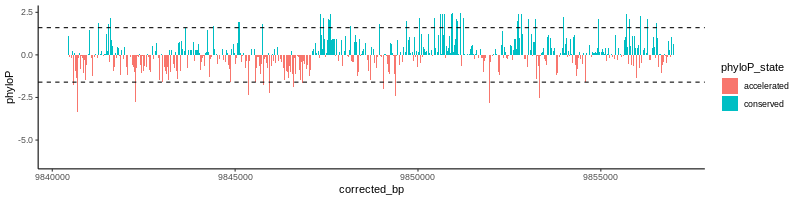

In [49]:
%%R -w 800 -h 200
region_start = 9840443
phyloP_scores = fread('phyloPscores.wig',skip =1, header = F) %>% set_colnames(c("phyloP")) %>% mutate(bp = seq(1,nrow(.),1),corrected_bp = bp + region_start- 1)
phyloP_scores %<>% mutate(phyloP_state = ifelse(phyloP > 0,"conserved","accelerated"))

SNPs = data.frame(SNP = c(9845152,9845301,9846908))

ggplot(phyloP_scores) +
    geom_bar(aes(x=corrected_bp, y = phyloP, fill = phyloP_state), stat = "identity") +
    #geom_bar(data = phyloP_scores %>% filter(abs(phyloP) < 1.6), aes(x = corrected_bp, y = phyloP), stat = "identity", fill = "gray") +
    geom_hline(aes(yintercept = 1.6), lty = 2) +
    geom_hline(aes(yintercept = -1.6), lty = 2) +
    theme_classic()

By 10bp windows

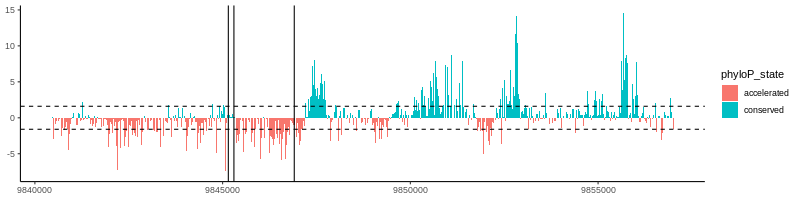

In [66]:
%%R -w 800 -h 200
region_start = 9840443
phyloP_scores = 
    fread('phyloPscores_10bp.wig', header = F) %>% 
    dplyr::select(V4,V5,V6) %>% 
    set_colnames(c("start","end","phyloP")) %>% 
    mutate(corrected_start = start + region_start- 1, corrected_end = end + region_start - 1)
phyloP_scores %<>% mutate(phyloP_state = ifelse(phyloP > 0,"conserved","accelerated"))

ggplot(phyloP_scores) +
    geom_rect(aes(xmin = corrected_start, xmax = corrected_end, ymin = 0, ymax = phyloP, fill = phyloP_state), stat = "identity") +
    #geom_bar(data = phyloP_scores %>% filter(abs(phyloP) < 1.6), aes(x = corrected_bp, y = phyloP), stat = "identity", fill = "gray") +
    geom_hline(aes(yintercept = 1.6), lty = 2) +
    geom_hline(aes(yintercept = -1.6), lty = 2) +
    geom_vline(data = SNPs, aes(xintercept = SNP)) +
   # xlim(c(min(phyloP_scores$corrected_start), max(phyloP_scores$corrected_end))) + 
    theme_classic()


In [80]:
%%R
exons

         V1      V2   V3
 1: 9737779 9737905 exon
 2: 9831100 9831184 exon
 3: 9831224 9831321 exon
 4: 9837604 9837757 exon
 5: 9850098 9850152 exon
 6: 9850932 9850941  utr
 7: 9850942 9851101 exon
 8: 9852831 9852919 exon
 9: 9855628 9855798 exon
10: 9855799 9856015  utr


Fig. 4 conservation panel

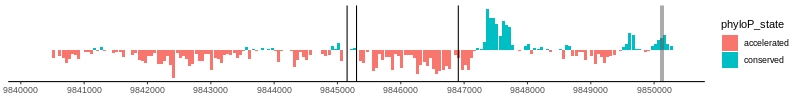

In [100]:
%%R -w 800 -h 100
region_start = 9840443
focal_SNP = 9845301
phyloP_scores = 
    fread('phyloPscores_50bp.wig', header = F) %>% 
    dplyr::select(V4,V5,V6) %>% 
    set_colnames(c("start","end","phyloP")) %>% 
    mutate(corrected_start = start + region_start- 1, corrected_end = end + region_start - 1)
phyloP_scores %<>% mutate(phyloP_state = ifelse(phyloP > 0,"conserved","accelerated"))

exons = fread('Ppol1.3.agouti.annotation.txt', header = F)
exons %<>% set_colnames(c('start','end','id'))

window_extension = 5000
ggplot(phyloP_scores) +
    geom_rect(aes(xmin = corrected_start, xmax = corrected_end, ymin = 0, ymax = phyloP, fill = phyloP_state), stat = "identity") +
    geom_rect(data = exons, aes(xmin = start, xmax = end, ymin = -Inf, ymax = Inf), alpha = 0.5) +
    #geom_hline(aes(yintercept = 1.6), lty = 2) +
    #geom_hline(aes(yintercept = -1.6), lty = 2) +
    geom_vline(data = SNPs, aes(xintercept = SNP)) +
    scale_x_continuous(limits = c(focal_SNP - window_extension, focal_SNP + window_extension), breaks = pretty_breaks(10)) + 
    theme_classic() +
    theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.line.y = element_blank())
    

#ggsave('~/temp/polionotus/RAWFIGS/phyloP_plot.svg')

## Tree

Plotting tree, for adding to the left side of the mVISTA plot to provide more context (Supplemental figure)

In [ ]:
a = read.nexus('~/temp/polionotus/RAWFIGS/mammal_1000.nex')
consensus_tree = ape::consensus(a)
write.tree(consensus_tree, '../conservation_plot/rodents_cladogram.nwk')

p = ggtree(consensus_tree, size = 1) + geom_tiplab(offset = 1) + ggplot2::xlim(c(0,100)) + geom_nodelab()
#
q = rotate(p, 31)
q = rotate(q, 40)
q = rotate(q, 41)
q = rotate(q, 42)
#
q = rotate(q, 32)
q = rotate(q, 37)
#
q = rotate(q, 51)
q = rotate(q, 52)


#pdf('~/temp/polionotus/RAWFIGS/fig5_tree.pdf', width = 2.5, height = 6)
#q
#dev.off()
